In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

import sklearn

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


#from tabulate import tabulate

In [3]:
def LoadData():
    global X_train, y_train, X_test, y_test, train_ind, test_ind, model_full 
    global feature_columns, response_column, n_features
    
    model_full = pd.read_csv('df.csv')
    
    key = 'is packer'
    keyOut = 'packer type'

    response_column = key
    feature_columns = list(model_full)
    feature_columns.remove('name')
    feature_columns.remove(key)
    feature_columns.remove(keyOut)
    
    #naknadno izbačeni featuresi
    feature_columns.remove('log_max_heap_reserve')
    feature_columns.remove('log_repeated_entry_sizes')
    feature_columns.remove('non_empty_metadatas')
    feature_columns.remove('certificate')
    feature_columns.remove('cert_malformed')
    feature_columns.remove('rich_header_valid')
    feature_columns.remove('max_opt_header_size')
   
    n_features = len(feature_columns)

    names = np.arange(model_full.shape[0])
    train_full, test_full, train_ind, test_ind = train_test_split(model_full, names, test_size=0.34, random_state=0)

    X_train  = train_full[feature_columns]
    y_train  = train_full[response_column]
    X_test   = test_full[feature_columns]
    y_test   = test_full[response_column]
            
    print('Number of train data: ', X_train.shape[0])
    print('Number of test data:  ', X_test.shape[0])
    print('Number of features:  ', n_features)
    return

In [4]:
def ROC_Curve(rf, auc):
    y_predicted = rf.predict_proba(X_test)[:, 1]
    false_positive, true_positive, _ = metrics.roc_curve(y_test, y_predicted)

    f = plt.figure()
    f.set_size_inches(18.5, 10.5, forward=True)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(false_positive, true_positive, color='darkorange', label='Random Forest')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve (area = %0.6f)' % auc)
    plt.legend(loc='best')
    plt.show()
    #f.savefig("ROC_curve.png")

In [5]:
def Print_Metrics(model):
    print('\nModel performance on the test data set:')

    y_predict_test  = np.asarray(model.predict(X_test))
    mse             = metrics.mean_squared_error(y_test.astype(int), y_predict_test.astype(int))
    logloss_test    = metrics.log_loss(y_test, y_predict_test)
    accuracy_test   = metrics.accuracy_score(y_test, y_predict_test)
    accuracy_test2  = model.score(X_test, y_test)
    F1_test         = metrics.f1_score(y_test, y_predict_test)
    precision_test  = metrics.precision_score(y_test, y_predict_test, average='binary')
    precision_test2 = metrics.precision_score(y_test, y_predict_test)
    recall_test     = metrics.recall_score(y_test, y_predict_test, average='binary')
    auc_test        = metrics.roc_auc_score(y_test, y_predict_test)
    r2_test         = metrics.r2_score(y_test.astype(int), y_predict_test.astype(int))
    
    header = ["Metric", "Test"]
    table  = [
               ["logloss",   logloss_test],
               ["accuracy",  accuracy_test],
               ["precision", precision_test],
               ["F1",        F1_test],
               ["r2",        r2_test],
               ["AUC",       auc_test]
             ]

    print(tabulate(table, header, tablefmt="fancy_grid"))

In [6]:
def Plot_predictor_importance(model, feature_columns):
    feature_importance = model.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    y_pos  = np.arange(feature_importance.shape[0]) + .5
    fig, ax = plt.subplots()
    f = fig
    fig.set_size_inches(18.5, 10.5, forward=True)
    ax.barh(y_pos, 
            feature_importance, 
            align='center', 
            color='green', 
            ecolor='black', 
            height=0.5)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(feature_columns)
    ax.invert_yaxis()
    ax.set_xlabel('Relative Importance')
    ax.set_title('Predictor Importance')
    plt.show()
    #f.savefig("feature_importance.png")

In [7]:
def Print_confusion_matrix(cm, auc, heading):
    print('\n', heading)
    print(cm)
    true_negative  = cm[0,0]
    true_positive  = cm[1,1]
    false_negative = cm[1,0]
    false_positive = cm[0,1]
    total = true_negative + true_positive + false_negative + false_positive
    accuracy = (true_positive + true_negative)/total
    precision = (true_positive)/(true_positive + false_positive)
    recall = (true_positive)/(true_positive + false_negative)
    misclassification_rate = (false_positive + false_negative)/total
    F1 = (2*true_positive)/(2*true_positive + false_positive + false_negative)
    print('accuracy.................%7.4f' % accuracy)
    print('precision................%7.4f' % precision)
    print('recall...................%7.4f' % recall)
    print('F1.......................%7.4f' % F1)
    print('auc......................%7.4f' % auc)

In [8]:
def Plot_learning_curve(model, title, X, y, ylim = None, cv = None,
                        n_jobs = 1, train_sizes = np.linspace(0.1, 1.0, 5)):
    f = plt.figure()
    f.set_size_inches(18.5, 10.5, forward=True)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(model, 
                                                            X, y,
                                                            cv = cv,
                                                            n_jobs = n_jobs,
                                                            train_sizes = train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()
    #f.savefig("learning_curve.png")
    return

In [9]:
def Train_Test():
    global model
    global y_predicted_test

    # Instantiate model
    rfc = RandomForestClassifier(n_estimators=800, 
                             random_state=42, 
                             criterion = 'entropy',#default='gini' 
                             min_samples_split =4, #default=2
                             bootstrap = False,    #uzorkovanje bez ponavljanja
                              
                             n_jobs=-1, #rad na maksimalnom broju procesora
                            )

    fit = rfc.fit(X_train, y_train)
    print('\nTraining finished\n')
    
    # Cross validation with 20 iterations to get smoother mean test and train
    # score curves, each time with 20% data randomly selected as a validation set.
    #cv_ = ShuffleSplit(n_splits = 10, test_size = 0.20, random_state = 0)
    #Plot_learning_curve(rfc, 
    #                    'Learning Curve',
    #                    model_full[feature_columns], model_full[response_column], 
    #                    cv = cv_,
    #                    n_jobs = 1)
    
    model = rfc
    print('\nModel:\n', model)

    print('\nFeature Importances:', model.feature_importances_)
    Plot_predictor_importance(model, feature_columns)

    y_predicted = model.predict(X_train)
    probabilities = model.predict_proba(X_train)

    c_report = metrics.classification_report(y_train, y_predicted)
    print('\nClassification report:\n', c_report)

    y_predicted_train = model.predict(X_train)
    cm = metrics.confusion_matrix(y_train, y_predicted_train)
    auc = metrics.roc_auc_score(y_train, y_predicted_train)
    Print_confusion_matrix(cm, auc, 'Confusion matrics of the training dataset')

    y_predicted = model.predict(X_test)
    cm = metrics.confusion_matrix(y_test, y_predicted)
    auc = metrics.roc_auc_score(y_test, y_predicted)

    ntotal = len(y_test)
    correct = y_test == y_predicted
    numCorrect = sum(correct)
    percent = round( (100.0*numCorrect)/ntotal, 6)
    print("\nCorrect classifications on test data: {0:d}/{1:d} {2:8.3f}%".format(numCorrect, ntotal, percent))
    prediction_score = 100.0*model.score(X_test, y_test)
    print('Random Forest Prediction Score on test data: %8.3f' % prediction_score)
    
    y_predicted_test = model.predict(X_test)
    cm = metrics.confusion_matrix(y_test, y_predicted_test)
    auc = metrics.roc_auc_score(y_test, y_predicted_test)
    Print_confusion_matrix(cm, auc, 'Confusion matrics of the test dataset')
    ROC_Curve(model, auc)
    Print_Metrics(model)
    return

Number of train data:  28897
Number of test data:   14887
Number of features:   52

Training finished


Model:
 RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=4, min_weight_fraction_leaf=0.0,
            n_estimators=800, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

Feature Importances: [0.00393557 0.01097467 0.01148433 0.00880792 0.06160925 0.00554158
 0.05386768 0.00796525 0.00516738 0.00548665 0.00541894 0.02665064
 0.00646031 0.00429956 0.00515625 0.00848732 0.00159587 0.00457645
 0.00249082 0.05767261 0.00700111 0.02573777 0.02614664 0.00708497
 0.01835615 0.01680477 0.01825904 0.01150723 0.01541406 0.05351877
 0.11742126 0.08603779 0.01401415 0.00645221 0.02357146 0.02353577
 0.02407549 0.00322739 0.00800496 0.005

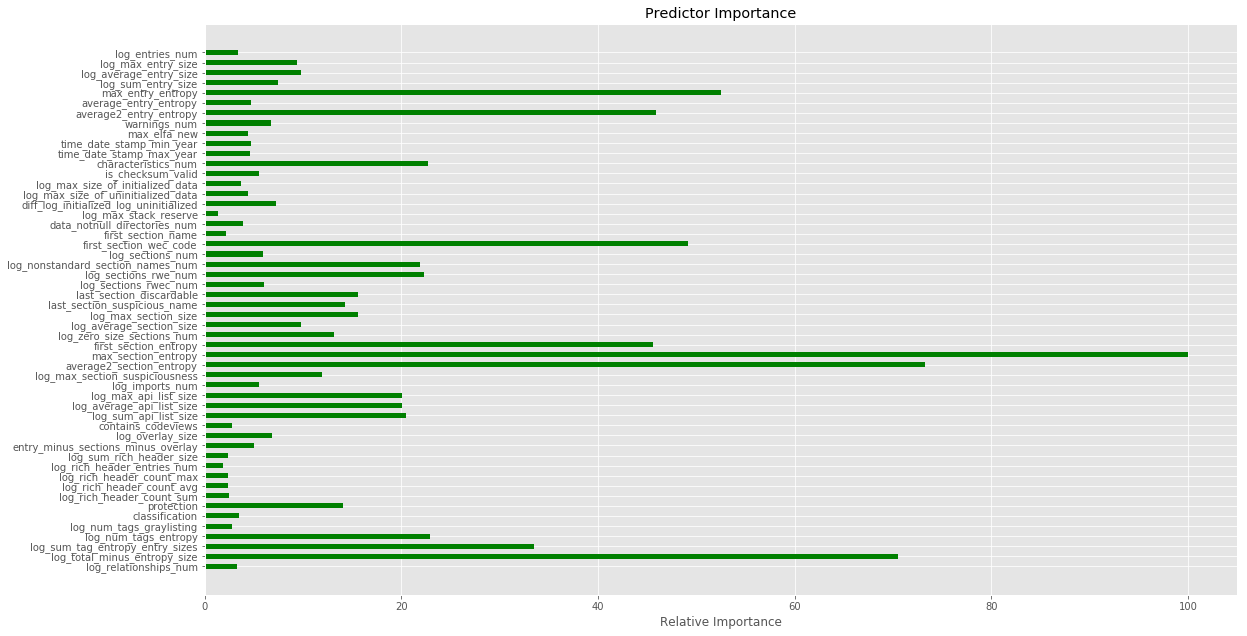


Classification report:
              precision    recall  f1-score   support

      False       1.00      1.00      1.00     14573
       True       1.00      1.00      1.00     14324

avg / total       1.00      1.00      1.00     28897


 Confusion matrics of the training dataset
[[14573     0]
 [    0 14324]]
accuracy................. 1.0000
precision................ 1.0000
recall................... 1.0000
F1....................... 1.0000
auc...................... 1.0000

Correct classifications on test data: 14819/14887   99.543%
Random Forest Prediction Score on test data:   99.543

 Confusion matrics of the test dataset
[[7371   18]
 [  50 7448]]
accuracy................. 0.9954
precision................ 0.9976
recall................... 0.9933
F1....................... 0.9955
auc...................... 0.9954


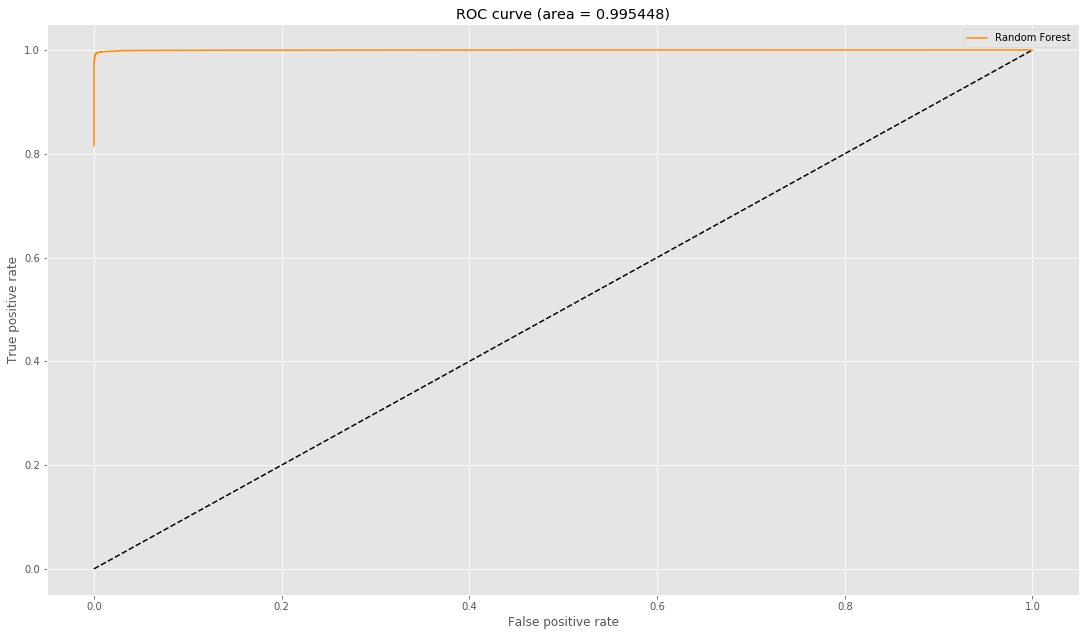


Model performance on the test data set:


NameError: name 'tabulate' is not defined

In [10]:
%%time
LoadData()
Train_Test()

In [11]:
podaciProba = {'prediction' : y_predicted_test,
              'original' : y_test}
podaciProba = pd.DataFrame(podaciProba)
tablica = pd.crosstab(podaciProba['original'], podaciProba['prediction'])

#tablica.plot.bar()
print('Postotak pogođenih:')
print(sum(y_predicted_test==y_test)/len(y_test))
tablica

Postotak pogođenih:
0.995432256331027


prediction,False,True
original,,
False,7371,18
True,50,7448


In [12]:
podaciProba = {'rezultati' : y_predicted_test,
              'originali' : model_full['packer type'][test_ind]}
podaciProba = pd.DataFrame(podaciProba)
tablica = pd.crosstab(podaciProba['originali'], podaciProba['rezultati'])

#tablica.plot.bar()
display(tablica)

#postoci po klasama
column1 = tablica[0]/tablica.apply(sum, axis=1) * 100
column2 = tablica[1]/tablica.apply(sum, axis=1) * 100

column3 = column1 + column2

d = {'False': column1, 'True': column2, 'Ukupno': column3}
df = pd.DataFrame(data=d)
print('\n\n' + '\033[1m' + 'Postotci po tipu packera:' + '\033[0m')
display(df)

rezultati,False,True
originali,,
t0,7371,18
t1,33,640
t2,10,688
t3,5,5013
t4,2,1107




Postotci po tipu packera:


,False,True,Ukupno
originali,,,
t0,99.756395,0.243605,100.0
t1,4.903418,95.096582,100.0
t2,1.432665,98.567335,100.0
t3,0.099641,99.900359,100.0
t4,0.180343,99.819657,100.0


In [13]:
r_not_packed = column1[0]/100
#print(r_not_packed)
r_overlay_and_cripters = (tablica[1][1] + tablica[1][2])/(tablica[0][1] + tablica[0][2]+tablica[1][1] + tablica[1][2])
#print(r_overlay_and_cripters)
r_protectors = column2[3]/100
#print(r_protectors)
r_compress = column2[4]/100
#print(r_compress)

bodovi = 8 * r_not_packed**3 * r_overlay_and_cripters * r_protectors * r_compress
print('Bodovi za kvalitetu rjesenja '+str(bodovi))

Bodovi za kvalitetu rjesenja 7.671070313276444
